# Abstract
#### Setting

        1. 채널별로 데이터 저장
        2. 비지도학습
        3. 결과 시각화

#### Method
        1. AutoEncoder 사용
        2. mae Loss값 이용
        3. Loss값 추출하여 quetone_graph.ipynb파일에 전달

#### Result

                        


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('../Processing/data/Type_A/아시아앤.csv')

In [56]:
## 원핫인코딩 - 요일생성
from datetime import datetime

day = []
for i in range(len(df)) :
    date = df['삽입날짜'][i]
    datetime_date = datetime.strptime(date, '%Y-%m-%d')

    dateDict = {0: '월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
    day.append(dateDict[datetime_date.weekday()])
df['day'] = day
df = pd.concat([df,pd.get_dummies(df['day'])],axis=1)

In [83]:
df['삽입날짜'] = pd.to_datetime(df['삽입날짜'])
df['삽입시간'] = pd.to_datetime(df['삽입시간'])

df['Year'] = df['삽입날짜'].dt.year 
df['Month'] = df['삽입날짜'].dt.month 
df['Day'] = df['삽입날짜'].dt.month 
df['Hour'] = df['삽입시간'].dt.hour 
df['Min'] = df['삽입시간'].dt.minute
df['Sec'] = df['삽입시간'].dt.second

In [84]:
df

,삽입날짜,삽입시간,광고타입,큐톤ID,서비스ID,채널명,OTV 채널번호,OTS 채널번호,서버 타입,Time,...,월,일,토,화,Year,Month,Day,Hour,Min,Sec
0,2021-10-01,2022-07-20 00:06:44,A,119,317,아시아앤,111,54,M,644,...,0,0,0,0,2021,10,10,0,6,44
1,2021-10-01,2022-07-20 00:08:52,A,119,317,아시아앤,111,54,M,852,...,0,0,0,0,2021,10,10,0,8,52
2,2021-10-01,2022-07-20 03:54:33,A,119,317,아시아앤,111,54,M,35433,...,0,0,0,0,2021,10,10,3,54,33
3,2021-10-01,2022-07-20 03:56:41,A,119,317,아시아앤,111,54,M,35641,...,0,0,0,0,2021,10,10,3,56,41
4,2021-10-01,2022-07-20 04:57:10,A,119,317,아시아앤,111,54,M,45710,...,0,0,0,0,2021,10,10,4,57,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12045,2022-04-14,2022-07-20 23:00:42,B,917,317,아시아앤,111,54,M,230042,...,0,0,0,0,2022,4,4,23,0,42
12046,2022-04-14,2022-07-20 23:53:21,A,119,317,아시아앤,111,54,M,235321,...,0,0,0,0,2022,4,4,23,53,21
12047,2022-04-14,2022-07-20 23:55:29,A,119,317,아시아앤,111,54,M,235529,...,0,0,0,0,2022,4,4,23,55,29
12048,2022-04-14,2022-07-20 23:57:20,B,917,317,아시아앤,111,54,M,235720,...,0,0,0,0,2022,4,4,23,57,20


In [85]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
# df_AXN['날짜'] = df_AXN['날짜'].dt.strftime("%Y%m%d").astype(int)
# df_AXN['시간'] = df_AXN['시간'].dt.strftime("%H%M%S").astype(int)
window_size = 10
batch_size = 8
features = ['Year','Month','Day','Hour','Min','Sec','큐톤ID','월','화','수','목','금','토','일']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=2, 
          callbacks=[checkpoint, early_stop])
          

model.load_weights(checkpoint_path)
# <tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7fa7e4312910>

(8, 10, 14)
(8, 14)
Epoch 1/2
1504/1505 [============================>.] - ETA: 0s - loss: 0.4960 - mae: 0.4960
Epoch 00001: val_loss improved from inf to 0.46899, saving model to /home/innerwave/aiffel/anomaly_detection/kospi/mymodel.ckpt
1505/1505 [==============================] - 32s 19ms/step - loss: 0.4959 - mae: 0.4959 - val_loss: 0.4690 - val_mae: 0.4690
Epoch 2/2
1504/1505 [============================>.] - ETA: 0s - loss: 0.4305 - mae: 0.4305
Epoch 00002: val_loss improved from 0.46899 to 0.41924, saving model to /home/innerwave/aiffel/anomaly_detection/kospi/mymodel.ckpt
1505/1505 [==============================] - 28s 19ms/step - loss: 0.4305 - mae: 0.4305 - val_loss: 0.4192 - val_mae: 0.4192


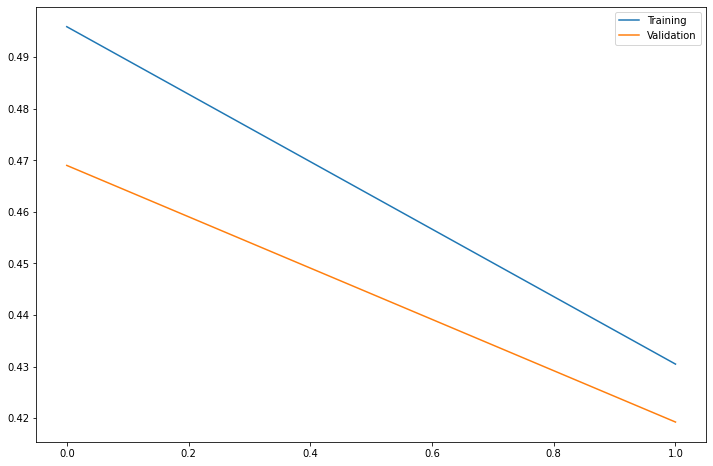

In [86]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

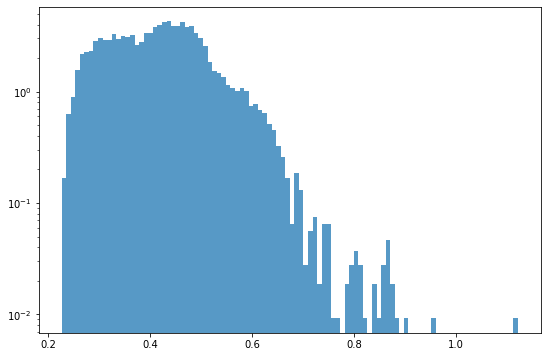

In [87]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [115]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss
lower_threshold = 0.3
upper_threshold = 0.307

print(len(test_df.loc[(test_df.Loss>lower_threshold) & (test_df.Loss<upper_threshold)]))
test_df.loc[(test_df.Loss>lower_threshold) & (test_df.Loss<upper_threshold)]

243


,삽입날짜,삽입시간,광고타입,큐톤ID,서비스ID,채널명,OTV 채널번호,OTS 채널번호,서버 타입,Time,...,일,토,화,Year,Month,Day,Hour,Min,Sec,Loss
16,2021-10-01,2022-07-20 15:55:14,A,119,317,아시아앤,111,54,M,155514,...,0,0,0,2021,10,10,15,55,14,0.305282
63,2021-10-02,2022-07-20 13:57:43,A,119,317,아시아앤,111,54,M,135743,...,0,1,0,2021,10,10,13,57,43,0.302117
97,2021-10-03,2022-07-20 03:50:44,A,119,317,아시아앤,111,54,M,35044,...,1,0,0,2021,10,10,3,50,44,0.300913
104,2021-10-03,2022-07-20 10:55:41,A,119,317,아시아앤,111,54,M,105541,...,1,0,0,2021,10,10,10,55,41,0.304726
113,2021-10-03,2022-07-20 12:58:17,A,119,317,아시아앤,111,54,M,125817,...,1,0,0,2021,10,10,12,58,17,0.302046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11588,2022-04-08,2022-07-20 18:59:09,B,917,317,아시아앤,111,54,M,185909,...,0,0,0,2022,4,4,18,59,9,0.303282
11594,2022-04-08,2022-07-20 20:58:45,B,917,317,아시아앤,111,54,M,205845,...,0,0,0,2022,4,4,20,58,45,0.306927
11892,2022-04-13,2022-07-20 02:04:34,B,917,317,아시아앤,111,54,M,20434,...,0,0,0,2022,4,4,2,4,34,0.303222
11940,2022-04-13,2022-07-20 17:58:44,B,917,317,아시아앤,111,54,M,175844,...,0,0,0,2022,4,4,17,58,44,0.302726


In [116]:
import pickle

# save
with open('../Processing/data/Type_A_anomaly_pickle/'+str(test_df['채널명'][0])+'.pickle', 'wb') as f:
    pickle.dump(test_df, f, pickle.HIGHEST_PROTOCOL)

test_df.to_csv('../Processing/data/Type_A/'+str(test_df['채널명'][0])+'.csv', index = False)